In [1]:
import requests
import sqlite3
from time import sleep
from datetime import datetime, timedelta, date
from requests.exceptions import ConnectTimeout

# Configuración de la conexión a la base de datos SQLite
conn = sqlite3.connect('proyecto.db')
c = conn.cursor()

# Método para crear la tabla tokens en la base de datos
def create_tokens_table():
    c.execute('''CREATE TABLE IF NOT EXISTS tokens (
                    access_token TEXT,
                    refresh_token TEXT,
                    expiration_date TEXT
                )''')

# Verificar si la tabla tokens existe y crearla si no existe
create_tokens_table()

# Método para obtener el access_token y refresh_token de la base de datos
def get_tokens():
    c.execute("SELECT * FROM tokens")
    tokens = c.fetchone()
    if tokens is None:
        return None
    access_token, refresh_token, expiration_date = tokens
    expiration_date = datetime.strptime(expiration_date, '%Y-%m-%d %H:%M:%S')
    return access_token, refresh_token, expiration_date

# Método para guardar el access_token y refresh_token en la base de datos
def save_tokens(access_token, refresh_token, expiration_date):
    c.execute("DELETE FROM tokens")
    c.execute("INSERT INTO tokens VALUES (?, ?, ?)",
            (access_token, refresh_token, expiration_date))
    conn.commit()

# Método para obtener un nuevo access_token y refresh_token
def get_new_tokens(refresh_token):
    url = "https://api.mercadolibre.com/oauth/token"
    payload = {
        "grant_type": "refresh_token",
        "client_id": "5030313997317379",
        "client_secret": "zTJax3dLAiog35gQdaOVEhTSwxXxbTTY",
        "refresh_token": refresh_token
    }
    response = requests.post(url, data=payload)
    response.raise_for_status()
    data = response.json()
    access_token = data['access_token']
    refresh_token = data['refresh_token']
    expires_in = data['expires_in']
    expiration_date = datetime.now() + timedelta(seconds=expires_in)
    expiration_date_str = expiration_date.strftime('%Y-%m-%d %H:%M:%S')
    save_tokens(access_token, refresh_token, expiration_date_str)
    return access_token, refresh_token, expiration_date_str

# Método para hacer la petición con el access_token
def make_request(access_token, url):
    headers = {"Authorization": f"Bearer {access_token}"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    data = response.json()
    return data

# Método para hacer una petición a la API
def do_request(url, params=None):
    tokens = get_tokens()
    if tokens is None or tokens[2] < datetime.now():
        refresh_token = tokens[1] if tokens is not None else input("Ingrese refresh_token: ")
        access_token, refresh_token, expiration_date = get_new_tokens(refresh_token)
    else:
        access_token, refresh_token, expiration_date = tokens
    
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    
    retries = 3  # Número máximo de reintentos
    retry_delay = 30  # Tiempo de espera en segundos antes de cada reintento
    
    for i in range(retries):
        try:
            response = requests.get(url, params=params, headers=headers, timeout=10)  # Establece un tiempo de espera de 10 segundos
            response.raise_for_status()
            data = response.json()
            return data
        except ConnectTimeout:
            print("Error de tiempo de espera de conexión. Se realizará un reintento después de 30 segundos...")
            sleep(retry_delay)
    
    print("Se ha excedido el número máximo de intentos de conexión. Se aborta la solicitud.")
    return None

# Método para obtener las visitas de cada producto
def get_product_visits(product_id):
    today = date.today()
    last_month = today - timedelta(days=30)
    
    endpoint = f"https://api.mercadolibre.com/visits/items"
    params = {
        "ids": product_id,
        "date_from": last_month.isoformat(),
        "date_to": today.isoformat()
    }

    # Aquí se utiliza la función do_request para realizar la solicitud con el access token
    response = do_request(endpoint, params=params)
    if response and isinstance(response, dict):
        product_visits = response.get(product_id)
        return product_visits
    
    return None



url = "https://api.mercadolibre.com/trends/MLC"

productos = {
    "tablets": "https://api.mercadolibre.com/sites/MLC/search?category=MLC82067",
    "notebooks": "https://api.mercadolibre.com/sites/MLC/search?category=MLC1652",
    "pcs": "https://api.mercadolibre.com/sites/MLC/search?category=MLC181025",
    "impresoras": "https://api.mercadolibre.com/sites/MLC/search?category=MLC1676"
}
# datos
datos_json = do_request(productos["tablets"])['results']

In [2]:
datos_json

[{'id': 'MLC933990141',
  'title': 'Apple iPad (9ª Generación) 10.2  Wi-fi 64gb - Color Plata',
  'condition': 'new',
  'thumbnail_id': '907886-MLU69497668167_052023',
  'catalog_product_id': 'MLC18498454',
  'listing_type_id': 'gold_pro',
  'permalink': 'https://www.mercadolibre.cl/apple-ipad-9-generacion-102-wi-fi-64gb-color-plata/p/MLC18498454',
  'buying_mode': 'buy_it_now',
  'site_id': 'MLC',
  'category_id': 'MLC82067',
  'domain_id': 'MLC-TABLETS',
  'thumbnail': 'http://http2.mlstatic.com/D_907886-MLU69497668167_052023-I.jpg',
  'currency_id': 'CLP',
  'order_backend': 1,
  'price': 319990,
  'original_price': 372990,
  'sale_price': None,
  'sold_quantity': 500,
  'available_quantity': 500,
  'official_store_id': 1078,
  'official_store_name': 'Apple',
  'use_thumbnail_id': True,
  'accepts_mercadopago': True,
  'tags': ['good_quality_thumbnail',
   'extended_warranty_eligible',
   'good_quality_picture',
   'immediate_payment',
   'cart_eligible',
   'best_seller_candidate',

In [1]:
%%time

import pandas as pd
import json
from time import sleep

# Método para crear la tabla en la base de datos
def create_table(table_name):
    c.execute(f'''CREATE TABLE IF NOT EXISTS {table_name} (
                    id TEXT,
                    title TEXT,
                    condition TEXT,
                    price INTEGER,
                    permalink TEXT,
                    thumbnail TEXT,
                    sold_quantity INTEGER,
                    available_quantity INTEGER,
                    seller_id TEXT,
                    seller_nickname TEXT,
                    brand TEXT,
                    line TEXT,
                    model TEXT,
                    shipping INTEGER,
                    visits_last_month INTEGER,
                    date_retrieved TEXT
                )''')
    
# Método para insertar los datos en la tabla
def insert_data(table_name, data):
    columns = ', '.join(data[0].keys())
    placeholders = ', '.join([':' + key for key in data[0].keys()])
    query = f"INSERT INTO {table_name} ({columns}) VALUES ({placeholders})"
    c.executemany(query, data)
    conn.commit()

# Método para obtener los datos de la tabla correspondientes a esta semana
def get_data(table_name):
    # Obtener la fecha de inicio y fin de la semana actual
    fecha_actual = datetime.now()
    fecha_inicio_semana = fecha_actual - timedelta(days=6)

    # Convertir las fechas a strings
    fecha_inicio_semana_str = fecha_inicio_semana.strftime('%Y-%m-%d %H:%M:%S')
    fecha_fin_semana_str = fecha_actual.strftime('%Y-%m-%d %H:%M:%S')

    # Consulta SQL para obtener los datos de la semana actual
    query = f"SELECT * FROM {table_name} WHERE date_retrieved BETWEEN ? AND ?"
    c.execute(query, (fecha_inicio_semana_str, fecha_fin_semana_str))

    # Obtener los nombres de las columnas
    column_names = [description[0] for description in c.description]

    # Obtener los datos de la consulta
    rows = c.fetchall()

    # Crear el DataFrame con los datos y los nombres de las columnas
    df = pd.DataFrame(rows, columns=column_names)

    return df

# Método para verificar si los datos de la API son más viejos a una semana
def check_data_age(table_name):
    c.execute(f"SELECT MAX(date_retrieved) FROM {table_name}")
    retrieved_date = c.fetchone()[0]
    if retrieved_date is None:
        return True
    else:
        retrieved_date = datetime.strptime(retrieved_date, '%Y-%m-%d %H:%M:%S')
        return datetime.now() - retrieved_date > timedelta(days=6)


# ...

def obtener_datos_por_pagina(total_resultados, url, table_name):
    resultados_por_pagina = 50
    paginas = total_resultados // resultados_por_pagina

    datos_filtrados_full = []

    for pagina in range(1, paginas + 1):
        parametros = {
            "offset": (pagina - 1) * resultados_por_pagina,
            "limit": resultados_por_pagina
        }
        respuesta = do_request(url, parametros)
        if "results" in respuesta and respuesta["results"]:
            datos_pagina = respuesta["results"]
        else:
            break

        for publicacion in datos_pagina:
            publicacion_filtrada = {
                "id": publicacion["id"],
                "title": publicacion["title"],
                "condition": publicacion["condition"],
                "price": publicacion["price"],
                "permalink": publicacion["permalink"],
                "thumbnail": publicacion["thumbnail"],
                "sold_quantity": publicacion["sold_quantity"],
                "available_quantity": publicacion["available_quantity"],
                "seller_id": publicacion["seller"]["id"],
                "seller_nickname": publicacion["seller"]["nickname"],
                "brand": None,
                "line": None,
                "model": None,
                "shipping": publicacion["shipping"]["free_shipping"],
                "visits_last_month": get_product_visits(publicacion["id"]),
                "date_retrieved": datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            }
            for atributo in publicacion["attributes"]:
                if atributo["id"] == "BRAND":
                    publicacion_filtrada["brand"] = atributo["value_name"]
                elif atributo["id"] == "LINE":
                    publicacion_filtrada["line"] = atributo["value_name"]
                elif atributo["id"] == "MODEL":
                    publicacion_filtrada["model"] = atributo["value_name"]

            datos_filtrados_full.append(publicacion_filtrada)

    # Inserta los datos en la tabla
    insert_data(table_name, datos_filtrados_full)

    dataframe = pd.DataFrame(datos_filtrados_full)

    return dataframe


total_resultados = 3950

# Ejecuta la función y obtiene los datos filtrados por página si es necesario

# PRIMERA FUNCIÓN
def obtener_data(producto):
    create_table(producto)
    if check_data_age(producto):
        df_product = obtener_datos_por_pagina(total_resultados, productos[producto], producto)
    else:
        # Obtiene los datos de la tabla
        df_product = get_data(producto)
    return df_product


# Llama a la función obtener_data con el producto "notebooks"
df_notebooks = obtener_data("notebooks")
df_tablets = obtener_data("tablets")
df_pcs = obtener_data("pcs")
df_impresoras = obtener_data("impresoras")
df_notebooks

NameError: name 'c' is not defined

In [4]:
datetime.now().date()

datetime.date(2023, 8, 4)

In [5]:
# Definir una función para agregar la columna 'producto'
# SEGUNDA FUNCIÓN
def agregar_producto(df):
    df = df.copy()
    df['producto'] = df['brand'] + ' '+ df['line'] + ' ' + df['model']
    return df

# Iterar sobre los DataFrames y agregar la columna 'producto' a cada uno de ellos
df_notebooks_result = agregar_producto(df_notebooks)
df_notebooks_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3938 entries, 0 to 3937
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  3938 non-null   object
 1   title               3938 non-null   object
 2   condition           3938 non-null   object
 3   price               3938 non-null   int64 
 4   permalink           3938 non-null   object
 5   thumbnail           3938 non-null   object
 6   sold_quantity       3938 non-null   int64 
 7   available_quantity  3938 non-null   int64 
 8   seller_id           3938 non-null   object
 9   seller_nickname     3938 non-null   object
 10  brand               3934 non-null   object
 11  line                3292 non-null   object
 12  model               3850 non-null   object
 13  shipping            3938 non-null   int64 
 14  visits_last_month   3938 non-null   int64 
 15  date_retrieved      3938 non-null   object
 16  producto            3256

In [6]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

#TERCERA FUNCIÓN
def calcular_metricas_producto(df):
    
    # Filtrar los resultados con menos de 50 visitas
    df = df[df['visits_last_month'] >= 50]
    
    # Agrupar por la columna "producto"
    grouped_df = df.groupby('producto')
    
    # Calcular la suma de "sold_quantity" y "visits_last_month" para cada grupo
    total_sold_quantity = grouped_df['sold_quantity'].sum()
    total_visits_last_month = grouped_df['visits_last_month'].sum()
    
    # Calcular el promedio de "price" para cada grupo
    average_price = grouped_df['price'].mean()
    
    # Obtener el "permalink" y "thumbnail" del primer producto detectado en cada grupo
    first_product_data = grouped_df.first()
    permalink = first_product_data['permalink']
    thumbnail = first_product_data['thumbnail']
    
    # Obtener el primer valor de "brand", "model" y "line" para cada grupo
    brand = first_product_data['brand']
    model = first_product_data['model']
    line = first_product_data['line']
    
    # Contar el número único de vendedores para cada grupo (producto)
    total_sellers = grouped_df['seller_id'].nunique()
    
     # Calcular la variable "sells_per_visit" (ventas por visita)
    sells_per_visit = total_sold_quantity / total_visits_last_month
    sells_per_visit = sells_per_visit.fillna(0)  # Reemplazar NaN con cero
    
    # Calcular la desviación estándar de "visits_last_month" para cada grupo (producto)
    std_visits_last_month = grouped_df['visits_last_month'].std()
    
    # Reemplazar NaN en std_visits_last_month con el promedio de las desviaciones estándar existentes
    std_visits_last_month_max = std_visits_last_month.max()
    std_visits_last_month = std_visits_last_month.fillna(std_visits_last_month_max)
    
    # Crear el nuevo DataFrame con las métricas calculadas
    result_df = pd.DataFrame({
        'product': total_sold_quantity.index,
        'brand': brand.values,
        'line': line.values,
        'model': model.values,
        'average_price': average_price.values,
        'total_sold_quantity': total_sold_quantity.values,
        'total_visits_last_month': total_visits_last_month.values,
        'total_sellers': total_sellers.values,
        'sells_per_visit': sells_per_visit.values,
        'std_visits_last_month': std_visits_last_month.values,
        'permalink': permalink.values,
        'thumbnail': thumbnail.values
        
    })
    
    # Ordenar el DataFrame por "total_visits_last_month" en orden descendente
    #result_df = result_df.sort_values(by='total_visits_last_month', ascending=False)
    result_df = result_df.sort_values(by='total_sellers', ascending=False)
    #result_df = result_df.sort_values(by='total_sold_quantity', ascending=False)

    
    return result_df

df_notebooks_pp = calcular_metricas_producto(df_notebooks_result)

df_notebooks_pp.head()

,product,brand,line,model,average_price,total_sold_quantity,total_visits_last_month,total_sellers,sells_per_visit,std_visits_last_month,permalink,thumbnail
174,Apple MacBook Air A1466,Apple,MacBook Air,A1466,3.047638e+05,18,14464,20,0.001244,963.675563,https://www.mercadolibre.cl/macbook-air-a1466-...,http://http2.mlstatic.com/D_953866-MLA50968332...
206,Apple MacBook Pro MacBook Pro,Apple,MacBook Pro,MacBook Pro,9.634014e+05,65,23097,19,0.002814,1744.159978,https://www.mercadolibre.cl/apple-macbook-pro-...,http://http2.mlstatic.com/D_626872-MLU69495171...
200,Apple MacBook Pro A2141,Apple,MacBook Pro,A2141,1.138730e+06,1,1965,12,0.000509,139.801239,https://articulo.mercadolibre.cl/MLC-100774765...,http://http2.mlstatic.com/D_773445-MLC50292571...
190,Apple MacBook Pro A1278,Apple,MacBook Pro,A1278,2.212626e+05,7,8465,11,0.000827,1358.107239,https://articulo.mercadolibre.cl/MLC-476058618...,http://http2.mlstatic.com/D_569811-MLC20652795...
194,Apple MacBook Pro A1502,Apple,MacBook Pro,A1502,4.203027e+05,8,7048,10,0.001135,1391.832669,https://articulo.mercadolibre.cl/MLC-123319318...,http://http2.mlstatic.com/D_906238-MLC52853415...


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import numpy as np

# Definir una clase personalizada para calcular la variable objetivo

# CLASE A DEFINIR
class ObjectiveValueCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, weight_total_visits=0.45, weight_sells_per_visit=0.15, weight_std_visits=0.3, weight_total_sellers = 0.1):
        self.weight_total_visits = weight_total_visits
        self.weight_sells_per_visit = weight_sells_per_visit
        self.weight_std_visits = weight_std_visits
        self.weight_total_sellers = weight_total_sellers
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        # Ajustar el MinMaxScaler a los datos
        self.scaler.fit(X)
        return self

    def transform(self, X):
        # Escalar los datos utilizando el MinMaxScaler
        X_scaled = self.scaler.transform(X)

        # Calcular la variable objetivo
        label = (self.weight_total_visits * X_scaled[:, 2]) + \
                (self.weight_sells_per_visit * X_scaled[:, 4]) + \
                (self.weight_std_visits * (1 - X_scaled[:, 5])) + \
                (self.weight_total_sellers * X_scaled[:, 3]) 


        return label

# CUARTA FUNCIÓN
def calculate_objective(df):
    # Seleccionar solo las columnas numéricas del DataFrame
    df_numeric = df.select_dtypes(include='number')
    
    # Definir el objetivo utilizando la clase personalizada ObjectiveValueCalculator
    objective_calculator = ObjectiveValueCalculator()
    df_label = objective_calculator.fit_transform(df_numeric)
    
    return df_label

# Llamada a la función utilizando el DataFrame df_notebooks_pp
df_notebooks_label = calculate_objective(df_notebooks_pp)

# Definir las transformaciones que se aplicarán a las columnas
# En este caso, aplicamos OneHotEncoder solo a la columna 'brand'
# QUINTA FUNCIÓN
def encode_dataframe(df):
    # Crear el transformador para One-Hot Encoding de la columna 'brand'
    one_hot = ColumnTransformer([
        ('', OneHotEncoder(sparse_output=False), ['brand'])
    ])

    # Aplicar las transformaciones al DataFrame original
    brand_encoded = one_hot.fit_transform(df)

    # Convertir la matriz resultante en un DataFrame
    df_encoded = pd.DataFrame(brand_encoded)

    # Obtener nombres de columnas para brand
    df_encoded.columns = one_hot.get_feature_names_out(input_features=df.columns)
    
    # Columnas a eliminar
    columns=['product', 'line', 'model', 'total_sold_quantity', 'brand', 'total_visits_last_month', 'total_sellers', 'sells_per_visit', 'std_visits_last_month', 'permalink', 'thumbnail']
    
    # Eliminar la columnas asignadas del DataFrame original
    df_without_brand = df.drop(columns=columns)
    # Concatenar el DataFrame codificado con el DataFrame original sin la columna 'brand'
    df_combined = pd.concat([df_without_brand, df_encoded], axis=1)

    return df_combined

# Llamada a la función utilizando el DataFrame df_notebooks_pp (como df)
df_combined = encode_dataframe(df_notebooks_pp)
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1410 entries, 174 to 1409
Data columns (total 57 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   average_price                                                     1410 non-null   float64
 1   __brand_1111                                                      1410 non-null   float64
 2   __brand_ASUS ROG Ally 7 120Hz 1080p Gaming Handheld AMD Ryzen Z1  1410 non-null   float64
 3   __brand_Acer                                                      1410 non-null   float64
 4   __brand_Alienware                                                 1410 non-null   float64
 5   __brand_Apple                                                     1410 non-null   float64
 6   __brand_Asus                                                      1410 non-null   float64
 7   __brand_Asus ROG                    

In [8]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_combined, df_notebooks_label, test_size=0.2, random_state=42)

# Definir las columnas numéricas y categóricas para el ColumnTransformer
numeric_features = ['average_price']

# Definir la Pipeline para la transformación de datos
preprocessing_pipeline = ColumnTransformer([
    ('numeric', MinMaxScaler(), numeric_features),
], remainder='passthrough')

# Suponiendo que ya tienes un DataFrame df_notebooks con las columnas 'producto' y 'permalink'
# Calculamos las métricas y obtenemos el nuevo DataFrame con los resultados
X_train_prepared = preprocessing_pipeline.fit_transform(X_train)

X_train_prepared

X_train_prepared.shape

X_train_prepared.shape

(1128, 57)

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

# Hacer predicciones en el conjunto de datos df_notebooks_mp
predicciones = lin_reg.predict(X_train_prepared)

predicciones.shape

# Calculo del error
lin_mae = mean_absolute_error(y_train, predicciones)
lin_mae

0.0882750518668088

In [10]:
predicciones

array([0.0770874 , 0.00065613, 0.05484009, ..., 0.0512085 , 0.05415344,
       0.05822754])

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train_prepared, y_train)

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_prepared, y_train)

scores_linear = cross_val_score(lin_reg, X_train_prepared, y_train,
                         scoring="neg_mean_squared_error", cv=5)
linear_rmse_scores = np.sqrt(-scores_linear)

scores_tree = cross_val_score(tree_reg, X_train_prepared, y_train,
                         scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-scores_tree)
    
scores_forest = cross_val_score(forest_reg, X_train_prepared, y_train,
                         scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-scores_forest)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(linear_rmse_scores)
display_scores(tree_rmse_scores)
display_scores(forest_rmse_scores)

def get_model_with_min_std(models, rmse_scores):
    min_std_idx = np.argmin([np.std(scores) for scores in rmse_scores])
    return models[min_std_idx]

# Crear una lista con los modelos correspondientes
models = [lin_reg, tree_reg, forest_reg]

# Crear una lista con los RMSE scores correspondientes
rmse_scores_list = [linear_rmse_scores, tree_rmse_scores, forest_rmse_scores]

# Encontrar el modelo con menor desviación estándar
best_model = get_model_with_min_std(models, rmse_scores_list)

Scores: [3.33023521e+10 4.98400986e+10 1.09021361e+10 7.78721063e+10
 5.79254053e+10]
Mean: 45968419687.14006
Standard deviation: 22653380042.44771
Scores: [0.1383681  0.15654798 0.15879707 0.15636902 0.14295854]
Mean: 0.15060814216559026
Standard deviation: 0.008292925966086077
Scores: [0.112267   0.13470737 0.13178747 0.13126765 0.11886264]
Mean: 0.1257784254034604
Standard deviation: 0.008675864247800013


In [12]:
X_test_prepared = preprocessing_pipeline.transform(X_test)
X_test_predict = best_model.predict(X_test_prepared)
X_test_mse = mean_absolute_error(y_test, X_test_predict)
X_test_mse

0.09469554097078617

In [13]:
# Obtener la importancia de características del modelo RandomForestRegressor
importancia_caracteristicas = best_model.feature_importances_

# Crear un DataFrame que muestre la importancia junto con el nombre de las características correspondientes
importancia_df = pd.DataFrame({'Característica': df_combined.columns, 'Importancia': importancia_caracteristicas})

# Ordenar las características por su importancia para determinar su importancia relativa
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

print(importancia_df)

                                       Característica   Importancia
0                                       average_price  8.105529e-01
28                                     __brand_Lenovo  2.691407e-02
3                                        __brand_Acer  2.339460e-02
38                                    __brand_Samsung  1.918160e-02
31                                        __brand_MSI  1.440553e-02
18                                         __brand_HP  1.323133e-02
10                                       __brand_Dell  1.175301e-02
49                                       __brand_VAIO  1.067515e-02
5                                       __brand_Apple  9.347837e-03
47                                    __brand_Toshiba  8.998610e-03
6                                        __brand_Asus  6.325512e-03
33                                    __brand_Olidata  5.556297e-03
8                                       __brand_Chuwi  5.022733e-03
20                                     __brand_H

In [14]:
X_total_prepared = preprocessing_pipeline.transform(df_combined)
X_total_predict = best_model.predict(X_total_prepared)

In [15]:
# Agregar las predicciones al DataFrame df_notebooks_pp
df_notebooks_pp['Prediction'] = X_total_predict

# Ordenar el DataFrame df_notebooks_pp por las predicciones en orden descendente
df_notebooks_predicted = df_notebooks_pp.sort_values(by='Prediction', ascending=False)

df_notebooks_predicted.head(20)

,product,brand,line,model,average_price,total_sold_quantity,total_visits_last_month,total_sellers,sells_per_visit,std_visits_last_month,permalink,thumbnail,Prediction
715,HP Notebook 14-ea0510la,HP,Notebook,14-ea0510la,9.599900e+05,10,16732,1,0.000598,1699.884702,https://www.mercadolibre.cl/notebook-hp-spectr...,http://http2.mlstatic.com/D_736771-MLC51250310...,0.422267
206,Apple MacBook Pro MacBook Pro,Apple,MacBook Pro,MacBook Pro,9.634014e+05,65,23097,19,0.002814,1744.159978,https://www.mercadolibre.cl/apple-macbook-pro-...,http://http2.mlstatic.com/D_626872-MLU69495171...,0.422267
174,Apple MacBook Air A1466,Apple,MacBook Air,A1466,3.047638e+05,18,14464,20,0.001244,963.675563,https://www.mercadolibre.cl/macbook-air-a1466-...,http://http2.mlstatic.com/D_953866-MLA50968332...,0.415135
530,Dell Vostro dell,Dell,Vostro,dell,1.249500e+04,4,195,2,0.020513,53.033009,https://articulo.mercadolibre.cl/MLC-126822172...,http://http2.mlstatic.com/D_787054-MLC31212440...,0.400635
588,HP 240 G8 240 G8,HP,240 G8,240 G8,4.817738e+05,30,2430,5,0.012346,451.375121,https://articulo.mercadolibre.cl/MLC-136492016...,http://http2.mlstatic.com/D_775228-MLC54580106...,0.379280
893,HP Victus 16-d0500la,HP,Victus,16-d0500la,7.699900e+05,350,81117,1,0.004315,7210.367848,https://www.mercadolibre.cl/notebook-gamer-hp-...,http://http2.mlstatic.com/D_771252-MLA49863936...,0.368209
200,Apple MacBook Pro A2141,Apple,MacBook Pro,A2141,1.138730e+06,1,1965,12,0.000509,139.801239,https://articulo.mercadolibre.cl/MLC-100774765...,http://http2.mlstatic.com/D_773445-MLC50292571...,0.361474
785,HP Pavilion 14-eh0101la,HP,Pavilion,14-eh0101la,7.412465e+05,12,1110,3,0.010811,260.064736,https://www.mercadolibre.cl/notebook-hp-pavili...,http://http2.mlstatic.com/D_922433-MLA53966628...,0.361016
190,Apple MacBook Pro A1278,Apple,MacBook Pro,A1278,2.212626e+05,7,8465,11,0.000827,1358.107239,https://articulo.mercadolibre.cl/MLC-476058618...,http://http2.mlstatic.com/D_569811-MLC20652795...,0.359966
1038,Lenovo IdeaPad NOTEBOOK LENOVO IDEAPAD 3 15.6 ...,Lenovo,IdeaPad,NOTEBOOK LENOVO IDEAPAD 3 15.6 I3-11TH 4GB SSD...,3.999900e+05,0,347,1,0.000000,121229.983991,https://articulo.mercadolibre.cl/MLC-103608716...,http://http2.mlstatic.com/D_927579-MLC52166396...,0.357955


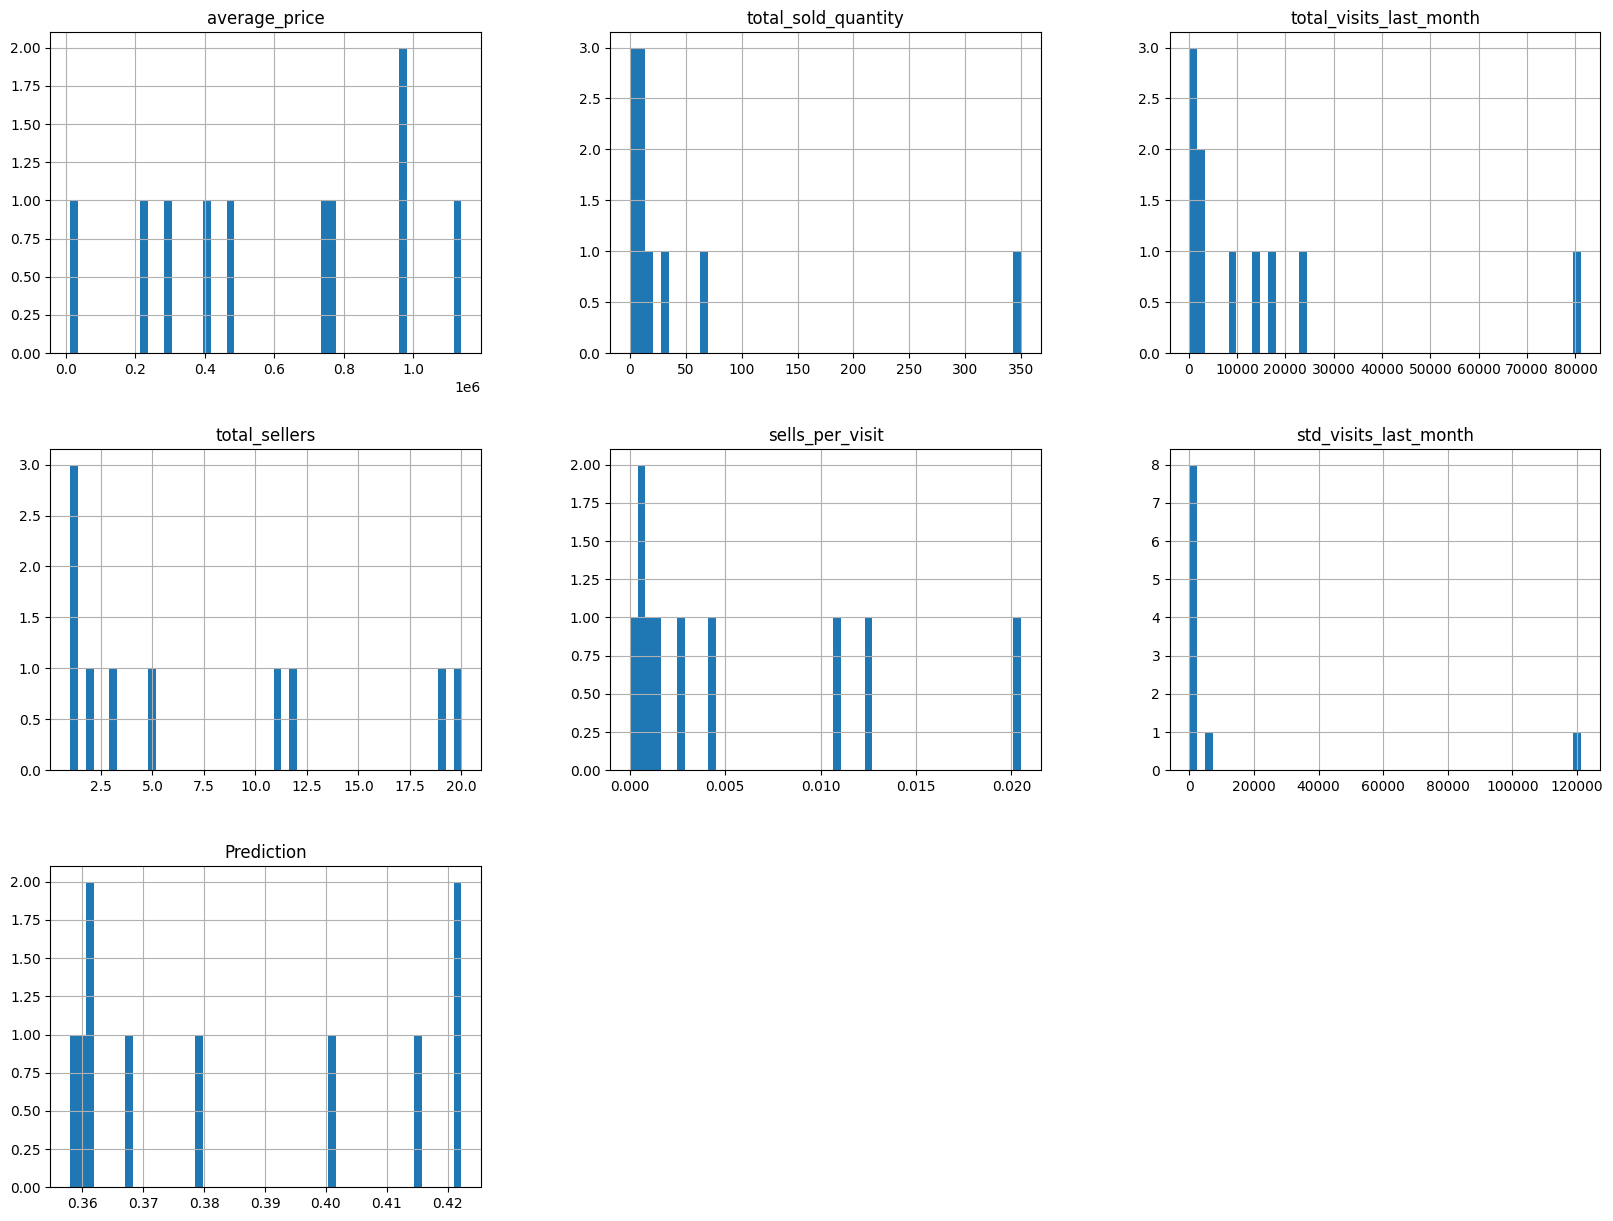

In [16]:
import matplotlib.pyplot as plt
# Obtener los datos de los primeros 20 productos del DataFrame df_notebooks_predicted
top_20_products = df_notebooks_predicted.head(10)

top_20_products.hist(bins=50, figsize=(20,15))
plt.show()

In [20]:
def total_process(nombre):
    # Obtiene los datos y los pasa a DataFrame
    df = obtener_data(nombre)
    # Agrega columna de productos
    df = agregar_producto(df)
    # Categorizar tabla por producto y agregar nuevos datos
    df_pp = calcular_metricas_producto(df)
    # Calcular variable objetivo
    df_result = calculate_objective(df_pp)
    # Codificar en One-Hot y eliminar columnas que no serán usadas en modelo
    df = encode_dataframe(df_pp) 
    # Separar entre train y test
    X_train, X_test, y_train, y_test = train_test_split(df, df_result, test_size=0.2, random_state=42)
    # Transformar valores númericos en valores consistentes con un modelo de Machine Learning
    X_train_prepared = preprocessing_pipeline.fit_transform(X_train)
    # Ajustar modelos a los datos
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_prepared, y_train)
    forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
    forest_reg.fit(X_train_prepared, y_train)
    tree_reg = DecisionTreeRegressor(random_state=42)
    tree_reg.fit(X_train_prepared, y_train)
    # Usar Cross Validation para ver el mejor modelo
    scores_linear = cross_val_score(lin_reg, X_train_prepared, y_train,
                         scoring="neg_mean_squared_error", cv=5)
    linear_rmse_scores = np.sqrt(-scores_linear)

    scores_tree = cross_val_score(tree_reg, X_train_prepared, y_train,
                             scoring="neg_mean_squared_error", cv=5)
    tree_rmse_scores = np.sqrt(-scores_tree)

    scores_forest = cross_val_score(forest_reg, X_train_prepared, y_train,
                             scoring="neg_mean_squared_error", cv=5)
    forest_rmse_scores = np.sqrt(-scores_forest)
    # Crear una lista con los modelos correspondientes
    models = [lin_reg, tree_reg, forest_reg]
    # Crear una lista con los RMSE scores correspondientes
    rmse_scores_list = [linear_rmse_scores, tree_rmse_scores, forest_rmse_scores]
    # Encontrar el modelo con menor desviación estándar
    best_model = get_model_with_min_std(models, rmse_scores_list)
    # Usamos el dataframe original de productos total para predecir
    X_total_prepared = preprocessing_pipeline.transform(df)
    # Predecimos
    X_total_predict = best_model.predict(X_total_prepared)
    # Agregar las predicciones al DataFrame df_pp
    df_pp['Prediction'] = X_total_predict
    # Ordenar el DataFrame df_pp por las predicciones en orden descendente
    df_predicted = df_pp.sort_values(by='Prediction', ascending=False)
    return df_predicted

predicciones_notebooks = total_process("Notebooks")
predicciones_tablets = total_process("Tablets")
predicciones_pcs = total_process("PCs")
predicciones_impresoras = total_process("Impresoras")

In [22]:
predicciones_impresoras.head(20)

,product,brand,line,model,average_price,total_sold_quantity,total_visits_last_month,total_sellers,sells_per_visit,std_visits_last_month,permalink,thumbnail,Prediction
135,Epson Impresora FX-890,Epson,Impresora,FX-890,74990.0,5,360,1,0.013889,152.735065,https://articulo.mercadolibre.cl/MLC-100117791...,http://http2.mlstatic.com/D_923637-MLC50137392...,0.328643
148,Epson Limpiarodillo Todas las Epson,Epson,Limpiarodillo,Todas las Epson,4500.0,200,4798,1,0.041684,30693.271776,https://articulo.mercadolibre.cl/MLC-436386393...,http://http2.mlstatic.com/D_788551-MLC45090472...,0.187413
115,Epson EcoTank L365,Epson,EcoTank,L365,10000.0,3,2409,1,0.001245,30693.271776,https://articulo.mercadolibre.cl/MLC-522442248...,http://http2.mlstatic.com/D_607149-MLC41190538...,0.187236
149,Epson Stylus CX4700,Epson,Stylus,CX4700,15000.0,0,337,1,0.000000,30693.271776,https://articulo.mercadolibre.cl/MLC-620819426...,http://http2.mlstatic.com/D_634728-MLC46393619...,0.187075
97,Dymo LetraTag Fit to DYMO LT-100H,Dymo,LetraTag,Fit to DYMO LT-100H,24597.0,2,1087,1,0.001840,30693.271776,https://articulo.mercadolibre.cl/MLC-552473425...,http://http2.mlstatic.com/D_743236-CBT43811560...,0.186767
4,Brother DCP-1 Series DCP-1512,Brother,DCP-1 Series,DCP-1512,26990.0,1,119,1,0.008403,30693.271776,https://articulo.mercadolibre.cl/MLC-105068708...,http://http2.mlstatic.com/D_827052-MLC51362740...,0.186690
150,Epson Stylus CX5600,Epson,Stylus,CX5600,35000.0,0,112,1,0.000000,30693.271776,https://articulo.mercadolibre.cl/MLC-172643452...,http://http2.mlstatic.com/D_640824-MLC69858731...,0.186432
55,Brother P-Touch PTH110PK,Brother,P-Touch,PTH110PK,43920.0,100,5610,1,0.017825,30693.271776,https://articulo.mercadolibre.cl/MLC-597922243...,http://http2.mlstatic.com/D_614954-MLA70649193...,0.186145
58,Canon Bubble Jet BJC-80,Canon,Bubble Jet,BJC-80,45000.0,0,838,1,0.000000,30693.271776,https://articulo.mercadolibre.cl/MLC-578038151...,http://http2.mlstatic.com/D_932391-MLC44719422...,0.186111
52,Brother P-Touch PTH-200,Brother,P-Touch,PTH-200,46360.0,250,13710,1,0.018235,30693.271776,https://articulo.mercadolibre.cl/MLC-531838668...,http://http2.mlstatic.com/D_623482-MLC69909344...,0.186067


In [ ]:
predicciones_impresoras.head(20)